In [2]:
!pip install kaggle

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
from tensorflow.keras import initializers
import numpy as np
import os
import random
import pickle
from shutil import copyfile
from zipfile import ZipFile

# Dataset

In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thoriqulumar","key":"b397925ba8bb2dd778212264e1a30a10"}'}

In [5]:
!mkdir kaggle

In [6]:
!mv kaggle.json /content/kaggle

In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"

In [8]:
!chmod 600. /content/kaggle/kaggle.json

chmod: invalid mode: ‘600.’
Try 'chmod --help' for more information.


In [9]:
!pwd

/content


In [10]:
!kaggle datasets download -d kutaykutlu/forest-fire

100% 2.46G/2.46G [00:35<00:00, 37.6MB/s]
100% 2.46G/2.46G [00:35<00:00, 75.2MB/s]


In [11]:
FILE_DIR = '/content/forest-fire.zip'
DATASET_DIR = '/content/Dataset'
TRAIN_DIR = r'/content/Dataset/Train'
VAL_DIR =  r'/content/Dataset/Val'
SMOKE_DIR = r'/content/Dataset/train-smoke'
FIRE_DIR = r'/content/Dataset/train_fire'

In [12]:
SPLIT_DATASET = 0.8

In [13]:
try:
  os.mkdir(DATASET_DIR)
  os.mkdir(TRAIN_DIR)
  os.mkdir(VAL_DIR)
except:
  print('directory exists')

In [14]:
Label = ['fire', 'smoke']
#create dir classes on train dir

for class_ in Label:
  try:
    data_dir = TRAIN_DIR+'/'+class_
    os.mkdir(data_dir)
  except:
    print('file exists')
  

#create dir classes on train dir
for class_ in Label:
  try:
    data_dir = VAL_DIR+'/'+class_
    os.mkdir(data_dir)
  except:
    print('file exists')

In [15]:
with ZipFile(FILE_DIR, 'r') as zip:
    zip.extractall(DATASET_DIR)
    zip.close()

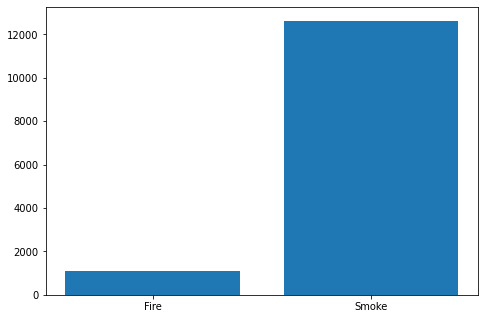

In [16]:
# Check distribution of datasets
import matplotlib.pyplot as plt

smoke = len(os.listdir(SMOKE_DIR))
fire = len(os.listdir(FIRE_DIR))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
label = ['Fire', 'Smoke']
data = [fire, smoke]
ax.bar(label,data)

plt.show()

### Adding New Dataset

In [17]:
# Adding new fire dataset
!kaggle datasets download -d phylake1337/fire-dataset

 99% 385M/387M [00:03<00:00, 70.5MB/s]
100% 387M/387M [00:03<00:00, 120MB/s] 


In [18]:
os.mkdir('Extension Dataset')

In [19]:
EXT_DATASET_DIR = '/content/Extension Dataset'
EXT_DATASET_FILE = '/content/fire-dataset.zip'

In [20]:
with ZipFile(EXT_DATASET_FILE, 'r') as zip:
    zip.extractall(EXT_DATASET_DIR)
    zip.close()

In [21]:
for f in os.listdir('/content/Extension Dataset/fire_dataset/fire_images'):
  file_dir = '/content/Extension Dataset/fire_dataset/fire_images/'+f
  dest_dir = FIRE_DIR+'/'+f
  copyfile(file_dir, dest_dir)

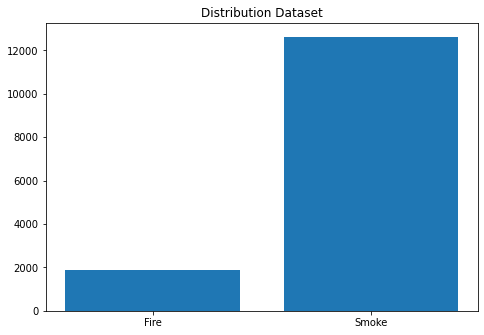

In [22]:
smoke = len(os.listdir(SMOKE_DIR))
fire = len(os.listdir(FIRE_DIR))


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Distribution Dataset')
label = ['Fire', 'Smoke']
data = [fire, smoke]
ax.bar(label,data)

plt.show()

In [23]:
def split_data(source, split_size, train_dir, val_dir):
    dataset = os.listdir(source)
    total_data = len(dataset)
    #mencari size train
    train_size = int(total_data * split_size)
    #merandom dataset
    shuffled = random.sample(dataset, len(dataset))
    #membagi dataset
    train_data = shuffled[0:train_size]
    val_data = shuffled[train_size:]
    

    for file in train_data:
        file_dir = source+'/'+file
        train_destination = train_dir +'/'+ file
        copyfile(file_dir, train_destination)

    for file in val_data:
        file_dir = source+'/'+file
        test_destination = val_dir +'/'+ file
        copyfile(file_dir, test_destination)

In [24]:
FIRE_TRAIN = '/content/Dataset/Train/fire'
FIRE_VAL = '/content/Dataset/Val/fire'

split_data(FIRE_DIR, SPLIT_DATASET, FIRE_TRAIN, FIRE_VAL)

In [25]:
SMOKE_TRAIN = '/content/Dataset/Train/smoke'
SMOKE_VAL = '/content/Dataset/Val/smoke'

split_data(SMOKE_DIR, SPLIT_DATASET, SMOKE_TRAIN, SMOKE_VAL)

In [26]:
len(os.listdir(FIRE_DIR))

1857

In [27]:
print('Train')
print('Fire : '+str(len(os.listdir(FIRE_TRAIN)))+' images')
print('Smoke : '+str(len(os.listdir(SMOKE_TRAIN)))+' images')

Train
Fire : 1485 images
Smoke : 10104 images


In [28]:
print('Val')
print('Fire : '+str(len(os.listdir(FIRE_VAL)))+' images')
print('Smoke : '+str(len(os.listdir(SMOKE_VAL)))+' images')

Val
Fire : 372 images
Smoke : 2527 images


# Pre-Processing

In [29]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

In [30]:
train_generator  = ImageDataGenerator(horizontal_flip=True,
                                      zoom_range = 0.4,
                                      rotation_range = 30,
                                      shear_range=0.4,
                                      rescale=1/255,
                                      fill_mode = 'nearest')

val_generator  = ImageDataGenerator(rescale=1/255)

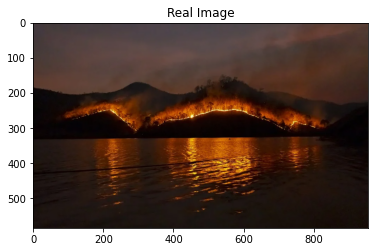

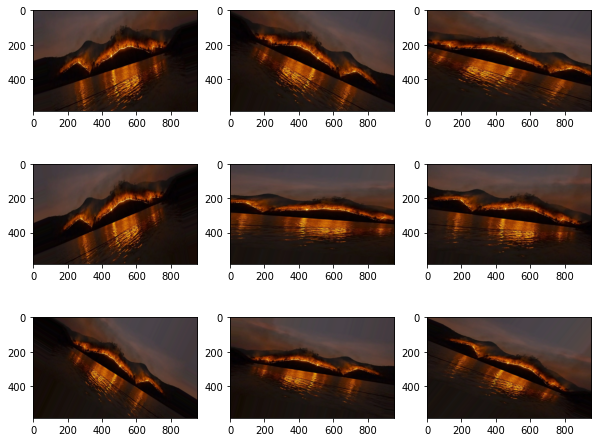

In [31]:
## Visualisasi Image Augmentation
import numpy as np
import matplotlib.pyplot as plt

ex_img = '/content/Dataset/train_fire/1.png'

img = load_img(ex_img)
img_arr = img_to_array(img)
plt.title('Real Image')
plt.imshow(img)
new_img = np.expand_dims(img_arr, 0)
imageDataGen = ImageDataGenerator(horizontal_flip=True,
                                      zoom_range = 0.4,
                                      rotation_range = 30,
                                      shear_range=0.4,
                                      fill_mode = 'nearest')
iterate = imageDataGen.flow(new_img, batch_size=1)

plt.figure(figsize=(10, 8))

for i in range(9):
  plt.subplot(330  + 1 + i)
  batch = iterate.next()
  image = batch[0].astype('uint8')
  plt.imshow(image)
plt.show()


In [32]:
train_data_generator = train_generator.flow_from_directory(TRAIN_DIR,
                                                           target_size= IMAGE_SIZE,
                                                           batch_size=BATCH_SIZE,
                                                           class_mode ='categorical')


val_data_generator = val_generator.flow_from_directory(VAL_DIR,
                                                      target_size= IMAGE_SIZE,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode ='categorical')

Found 11589 images belonging to 2 classes.
Found 2899 images belonging to 2 classes.


# Utils

In [33]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99) and (logs.get('val_accuracy')>0.93) :
            print("\nReached!")
            self.model.stop_training = True

In [34]:
def lr_scheduler(epochs, lr):
    if epochs > 50 and epochs < 75:
        lr = 0.001
    if epochs > 75:
        lr = 0.0001
    return lr

In [35]:
callback = myCallback()

In [36]:
scheduler = LearningRateScheduler(lr_scheduler, verbose=1)

# Transfer Learning

In [58]:
IMAGE_SHAPE = (224,224,3)

In [59]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',input_tensor=Input(shape=IMAGE_SHAPE))

In [60]:
for layer in base_model.layers:
  layer.trainable = False

In [61]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [62]:
model.summary( )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_3 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               16056576  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

In [63]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [64]:
history = model.fit(train_data_generator,
                    validation_data=val_data_generator,
                    steps_per_epoch=20,
                    epochs=20,
                    validation_steps=4)

Epoch 1/20
20/20 [==============================] - 27s 1s/step - loss: 0.9082 - accuracy: 0.8157 - val_loss: 0.0345 - val_accuracy: 0.9766
Epoch 2/20
20/20 [==============================] - 24s 1s/step - loss: 0.2509 - accuracy: 0.9330 - val_loss: 0.1339 - val_accuracy: 0.9688
Epoch 3/20
20/20 [==============================] - 23s 1s/step - loss: 0.0881 - accuracy: 0.9739 - val_loss: 0.0240 - val_accuracy: 0.9844
Epoch 4/20
20/20 [==============================] - 23s 1s/step - loss: 0.1382 - accuracy: 0.9598 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 5/20
20/20 [==============================] - 23s 1s/step - loss: 0.0595 - accuracy: 0.9882 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 6/20
20/20 [==============================] - 25s 1s/step - loss: 0.0925 - accuracy: 0.9720 - val_loss: 0.0226 - val_accuracy: 0.9922
Epoch 7/20
20/20 [==============================] - 24s 1s/step - loss: 0.0769 - accuracy: 0.9745 - val_loss: 0.0478 - val_accuracy: 0.9844
Epoch 8/20
20/20 [==

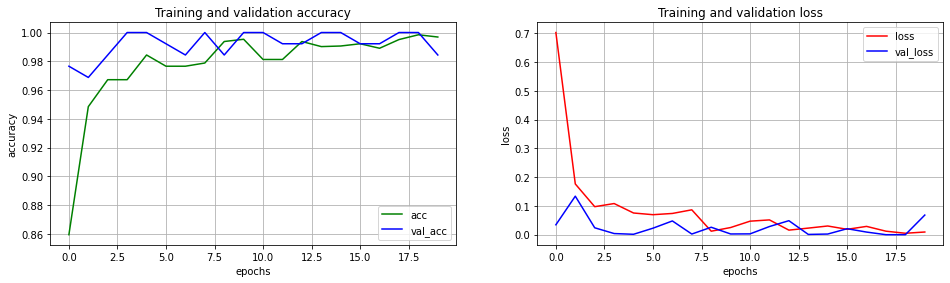

In [65]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))
plt.figure(figsize=(16,9))
plt.subplot(221)

plt.grid(True)
plt.plot(epochs, acc, 'g')
plt.plot(epochs, val_acc, 'b')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['acc', 'val_acc'], loc='best')
plt.title('Training and validation accuracy')

plt.subplot(222)
plt.grid(True)
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.title('Training and validation loss')

plt.show()

In [67]:
saved_model_dir = '/content/'
tf.saved_model.save(model, saved_model_dir)

converter= tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /content/assets


In [70]:
with open('model_transfer.tflite', 'wb') as f:
  f.write(tflite_model)

In [71]:
model.save_weights("model_transfer.h5")